In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
from IPython.display import clear_output

import quick_pp.las_handler as las
from quick_pp.lithology import sand_shale_model
from quick_pp.plotter.well_plots import plotly_log
from quick_pp.qaqc.qaqc import badhole_flag, mask_outside_threshold, neu_den_xplot_hc_correction

In [5]:
with open('X10_raw.las', 'rb') as f:
    df, header, _ = las.read_las_file(f)

# Mask outside threshold
df = mask_outside_threshold(df, True)

# Flag bad hole
df = badhole_flag(df) if 'CALI' in df.columns else df

clear_output()

In [ ]:
args = {
    # 'dry_clay_point': (0.27, 2.8)
    # 'silt_line_angle': 119
}

neu_den_df = df[['DEPTH', 'NPHI', 'RHOB']].dropna()
vsand, vcld, xplot = sand_shale_model(
    neu_den_df['NPHI'], neu_den_df['RHOB'], xplot=True, **args)
df_ss_model = pd.DataFrame(
    {'VSAND': vsand, 'VCLW': vcld},
    index=neu_den_df.DEPTH
)
df_ssc = df.merge(df_ss_model, how='left', on='DEPTH', suffixes=('_ORI', ''))

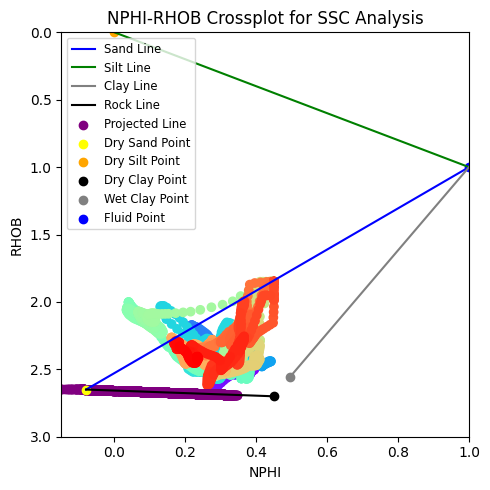

In [ ]:
xplot

In [ ]:
fig = plotly_log(df_ssc)
fig.show()
# fig.write_html('plot.html')

## Hydrocarbon Correction

In [ ]:
# Correct NPHI and RHOB for HC
df_corr = df.copy()
nphihc, rhobhc = neu_den_xplot_hc_correction(df_corr['NPHI'], df_corr['RHOB'], gr=df_corr['GR'],
                                             dry_sand_point=(-.02, 2.65),
                                             dry_clay_point=(.33, 2.7),
                                             corr_degree=50)
df_corr[['NPHI', 'RHOB']] = pd.DataFrame({'NPHI': nphihc, 'RHOB': rhobhc}).astype(float)

args = {
    # 'dry_clay_point': (0.27, 2.8)
    # 'silt_line_angle': 119
}

neu_den_df = df_corr[['DEPTH', 'NPHI', 'RHOB']].dropna()
vsand, vcld, xplot = sand_shale_model(
    neu_den_df['NPHI'], neu_den_df['RHOB'], xplot=True, **args)
df_ss_model = pd.DataFrame(
    {'VSAND': vsand, 'VCLW': vcld},
    index=neu_den_df.DEPTH
)
df_ssc_hc = df_corr.merge(df_ss_model, how='left', on='DEPTH', suffixes=('_ORI', ''))

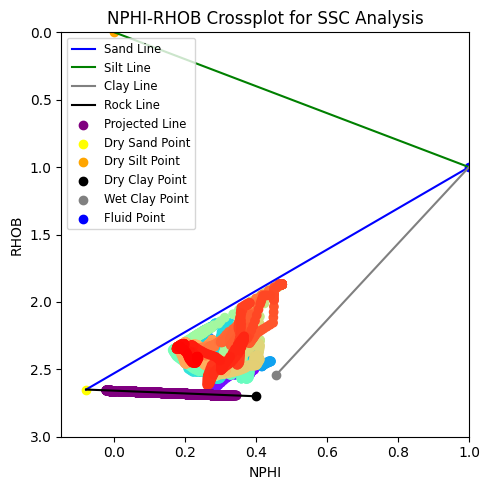

In [ ]:
xplot

In [ ]:
fig = plotly_log(df_ssc_hc)
fig.show()
# fig.write_html('plot.html')